Skipping, found downloaded files in "./alzheimer-mri-dataset" (use force=True to force download)
root directory Dataset
Data directories:
train, test classes: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented'] ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
train, test dataset sz: 5120 1280


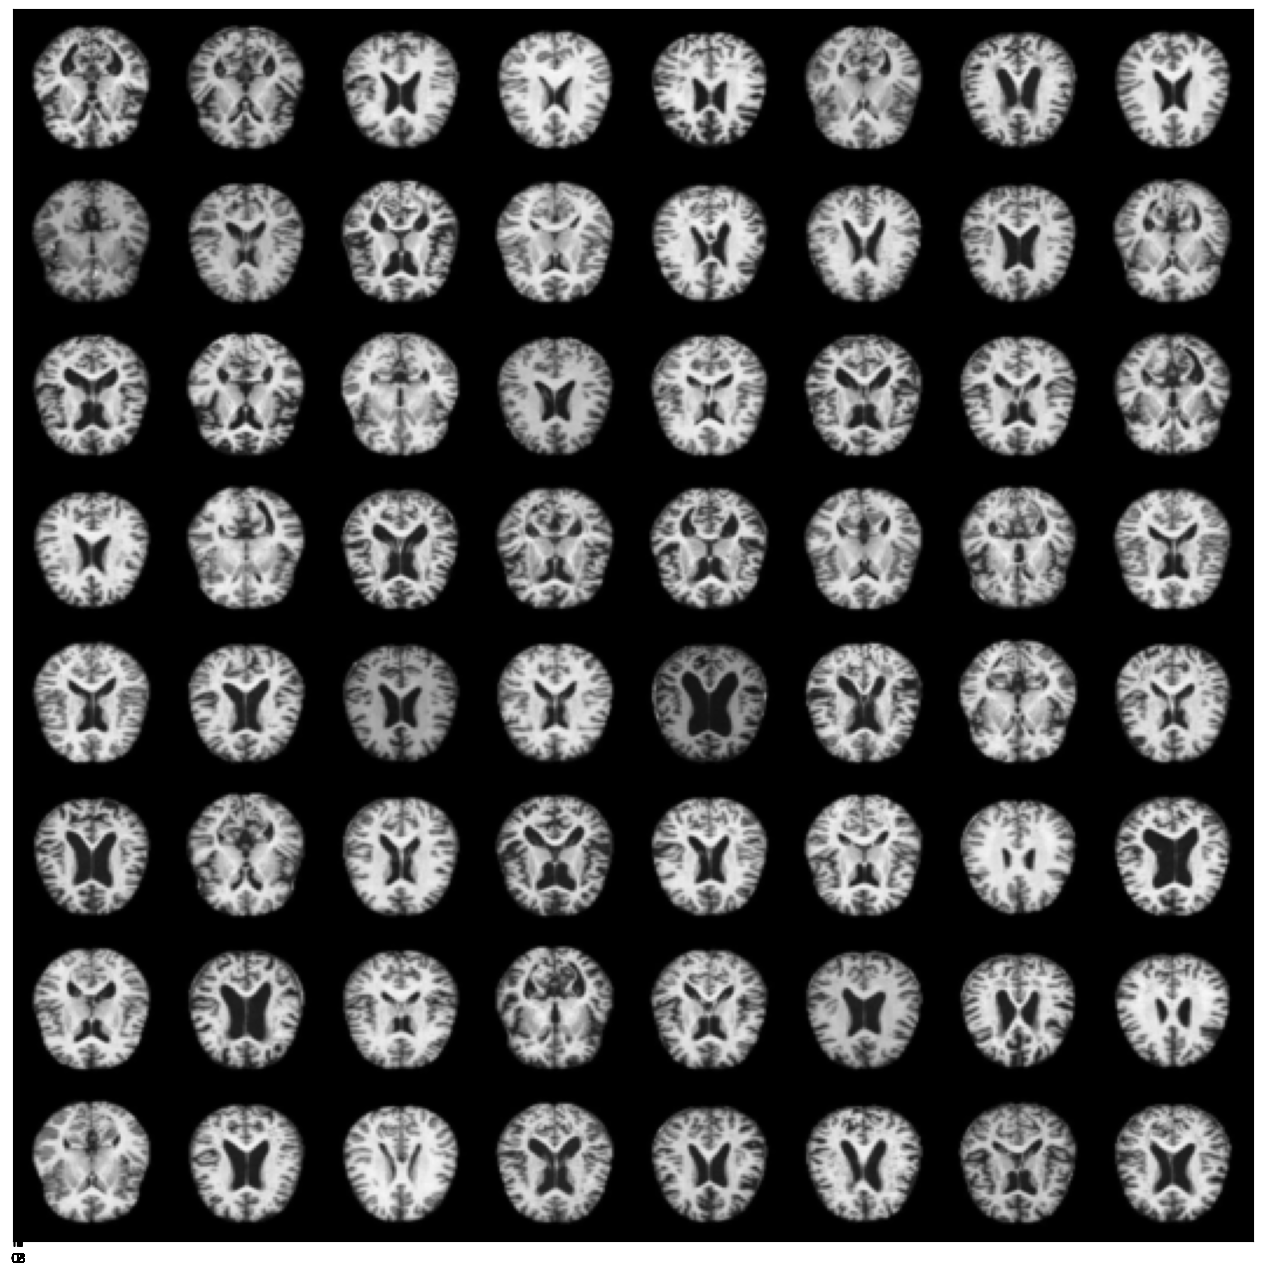

In [ ]:
# Fetch the data
# (a) Download the data
# (b) Show the batch of the images
!pip install opendatasets --upgrade --quiet
import opendatasets as od
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


%matplotlib inline


DATASET_URL = 'https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset'
DATA_DIR = 'alzheimer-mri-dataset'


class AlzheimerDataLoader(object):
    def __init__(self, data_path, stats):
        self.data_path = data_path
        self.stats = stats


    def fetch_data(self, dataset_url):
        od.download(dataset_url)

    def denorm(self, img_tensors):
        return img_tensors * self.stats[1][0] + self.stats[0][0]

    def show_images(self, images, labels, num_imgs=64):
        fig, ax = plt.subplots(figsize=(16, 16))
        # plt.xlabel(labels)
        ax.set_xticks(labels);
        ax.set_yticks([])
        ax.imshow(make_grid(self.denorm(images.detach()[:num_imgs]), nrow=8).permute(1, 2, 0), aspect='auto')

    def show_batch(self, data_batch, num_images, num_batches):
        for images, labels in data_batch:
            self.show_images(images, labels, num_images)
            break #showing only num_batches


    def load_data(self, image_sz, batch_sz, train_pct):
        root_dir = os.listdir(self.data_path)[0] #listing directories
        print("root directory", root_dir)
        print("Data directories:")


        # This function does couple of things
        # a) It fetches all the images together with it's lables. Data with different classes is organized
        # by separate folders
        # b) converting image to tensor 4 dimensions: (batch, channel, 64 pixel, 64 pixel)
        # c) It normalizes the data. For example, it can be from -1 to 1

        dataset = ImageFolder(root = self.data_path + "/" + root_dir,
                        transform=T.Compose([
                        T.Resize(image_sz),
                        T.CenterCrop(image_sz),
                        T.ToTensor(), #converting image to tensor 4 dimensions: (batch, channel, 64 pixel, 64 pixel)
                        T.Normalize(*self.stats)]))

        train_size = int(train_pct * len(dataset))
        sizes = [train_size, len(dataset) - train_size]

        # It shuffles the data and gives the train and test datasets based on the given sizes
        # By using the same seed shuffling can always be repeated
        train_ds, test_ds = torch.utils.data.random_split(dataset, sizes, generator=torch.Generator().manual_seed(8192))
        print("train, test classes:", train_ds.dataset.classes, test_ds.dataset.classes)
        print("train, test dataset sz:", len(train_ds), len(test_ds))

        self.train_batch = DataLoader(train_ds, batch_sz, shuffle=True, num_workers=3, pin_memory=True)#gives data in batches by bathc_size

        self.test_batch = DataLoader(test_ds, batch_sz, shuffle=True, num_workers=3, pin_memory=True)#gives data in batches by bathc_size

normalize_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Mean and standard deviation for RGB channels
                                                   # Normalize the pixels between -1 and 1
                                                   # Normalize the pixels between 0 and 1
image_sz = 64
batch_sz = 128
train_pct = 0.8
alz_data_loader = AlzheimerDataLoader(DATA_DIR, normalize_stats)

alz_data_loader.fetch_data(DATASET_URL)
alz_data_loader.load_data(image_sz, batch_sz, train_pct)
alz_data_loader.show_batch(alz_data_loader.train_batch, 64, 1)




In [1]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield self.to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

    def to_device(self, data, device):
        """Move tensor(s) to chosen device"""
        if isinstance(data, (list, tuple)):
            return [to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


In [ ]:
## This class helps in classifying the alzheimer images with different severities.
from torchvision.models import resnet50, ResNet50_Weights, vgg16
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F


class AlzheimerImageClassification(object):
    def __init__(self, data_loader, device):
        self.data_loader = data_loader
        self.device = device

    def get_pre_trained_model(self, pre_model):
        torch.cuda.empty_cache()
        torch.manual_seed(8192)
        if pre_model == "resnet18":
            self.model = resnet50(pretrained=True)
        else:
            self.model = vgg16(pretrained=True)
        self.model.to(self.device)
        self.model.eval()

    def accuracy(self, out, labels):
        _,pred = torch.max(out, dim=1)
    # print(pred, labels)
        return torch.sum(pred==labels).item()




    def fit(epochs, lr, train_dl, test_dl, start_idx=1, seed=8192):
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, 128) #why 128
        net.fc = net.fc.cuda()



        # for param in net.parameters():
        #     param.requires_grad = False
        train_epoch_accuracy = []
        test_epoch_accuracy = []
        train_epoch_loss = []
        test_epoch_loss = []
        torch.cuda.empty_cache()
        torch.manual_seed(seed)
        net = net.to(device)
        net.train()

    # Losses & scores


        # Create optimizers
        opt_d = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.5, 0.999))


        for epoch in range(epochs):
            train_loss = 0
            train_running_accuracy = 0
            for real_images, labels in tqdm(train_dl):
                # Train discriminator
                opt_d.zero_grad()
                real_preds = net(real_images)
                real_targets = labels
                # print("real_preds, labels", real_preds, labels)
                print(real_preds.shape, labels.shape)
                real_loss = F.cross_entropy(real_preds, real_targets)
                real_loss.backward()
                opt_d.step()
                train_loss += real_loss.item()
                sum = accuracy(real_preds, real_targets)
                # print("sum", sum)
                train_running_accuracy += sum
                # loss_d = train_discriminator(real_images, labels, opt_d)
            # real_scores.append(real_score)
            mean_train_loss = train_loss / len(train_dl)
            # print("train_dl length:", len(train_dl.dl.dataset))
            train_accuracy = 100 * (train_running_accuracy / len(train_dl.dl.dataset))
            train_epoch_accuracy.append(train_accuracy)
            train_epoch_loss.append(mean_train_loss)

            with torch.no_grad():
                net.eval()
                test_loss = 0
                test_running_accuracy = 0
                for data_t, target_t in tqdm(test_dl):
                    real_preds = net(data_t)

                    real_targets = target_t
                    loss = F.cross_entropy(real_preds, real_targets)
                    test_loss += loss.item()
                    test_running_accuracy += accuracy(real_preds, real_targets)
            mean_test_loss = test_loss / len(test_dl)
            test_accuracy = 100 * (test_running_accuracy / len(test_dl.dl.dataset))
            test_epoch_accuracy.append(test_accuracy)
            test_epoch_loss.append(mean_test_loss)

            # Log losses & scores (last batch)
            print("Epoch [{}/{}],  train loss: {:.4f}, train_accuracy: {:.4f}".format(
                epoch+1, epochs, mean_train_loss, train_accuracy))
            print("Mean Test loss: {:.4f}, test_accuracy: {:.4f}", mean_test_loss, test_accuracy)

            # Save generated images
            # save_samples(dir_idx, epoch+start_idx, fixed_latent, show=False)

        torch.save(net, "Discriminator_Model")


lr = 0.0001
epochs = 31

# train_dl = DeviceDataLoader(df.train_dl, device)
dev_test_dl = DeviceDataLoader(df.test_dl, device)

dev_train_dl = DeviceDataLoader(df.train_dl, device)


history = fit(epochs, lr, dev_train_dl, dev_test_dl)




